# Gaussianization Flows (Details)

In [1]:
#@title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config
# import chex
config.update("jax_enable_x64", False)

import objax
import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss

KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Demo Data

<Figure size 432x288 with 0 Axes>

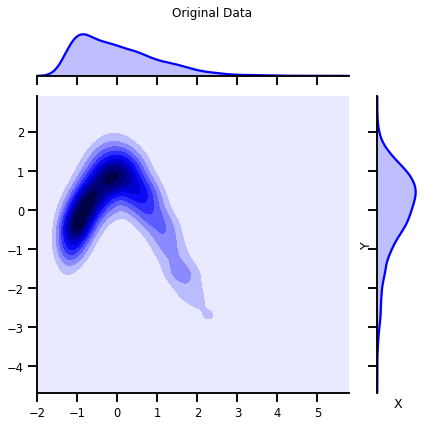

In [3]:
from sklearn.preprocessing import StandardScaler
# %%wandb
# get data
n_samples = 2_000
n_features = 2
data = get_classic(n_samples)
data = StandardScaler().fit_transform(data)

# plot data
plot_joint(data, "blue", "Original Data", kind='kde', logger=False)

In [4]:
# convert this into a Jax array
X = jnp.array(data, dtype=np.float32)

## Layers

### Layer I - Mixture Gaussian CDF Transform

#### Initialize Layer

In [5]:
from rbig_jax.transforms.parametric.mixture import MixtureGaussianCDF

# layer parameters
n_components = 10

# create layer
init_func = MixtureGaussianCDF(n_components=n_components)

#### Initialize Parameters

In [6]:

# initialize the keys
rng, params_rng = jax.random.split(KEY, 2)

# initialize the layer
params, forward_f, inverse_f = init_func(rng=params_rng, n_features=n_features)


#### Forward/Inverse Transformation

In [7]:
%%time

# forward transformation
X_l1, log_abs_det = forward_f(params, X)

# inverse transformation
X_approx, log_abs_det = inverse_f(params, X_l1)

CPU times: user 9.56 s, sys: 708 ms, total: 10.3 s
Wall time: 5.23 s


#### Demo Plot

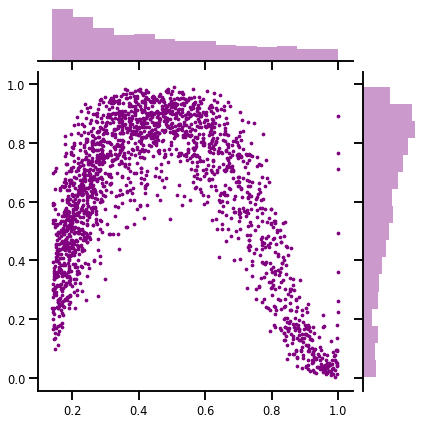

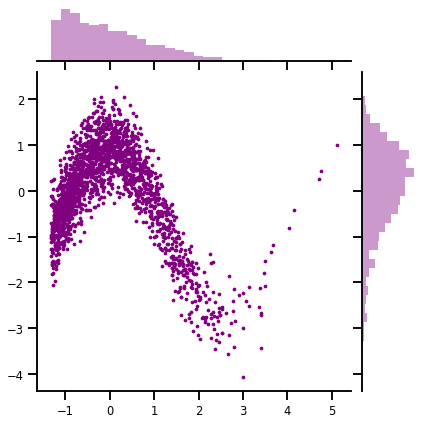

In [8]:
# plot data
sns.jointplot(X_l1[:, 0], X_l1[:, 1], s=5, color='purple')
sns.jointplot(X_approx[:, 0], X_approx[:, 1], s=5, color='purple')

### Layer II - Inverse Gaussian CDF Transformation

#### Initialize Layer

In [9]:
from rbig_jax.transforms.inversecdf import InverseGaussCDF

# create layer
init_func = InverseGaussCDF(eps=1e-5)

#### Initialize Parameters

In [10]:

# initialize the keys
rng, params_rng = jax.random.split(rng, 2)

# initialize the parameters
params, forward_f, inverse_f = init_func(rng=params_rng, n_features=n_features,)

#### Forward/Inverse Transformation

In [11]:
%%time

# forward transformation
X_l2, log_abs_det = forward_f(params, X_l1)
X_l1_approx, _ = inverse_f(params, X_l2)

CPU times: user 456 ms, sys: 9.35 ms, total: 465 ms
Wall time: 450 ms


/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


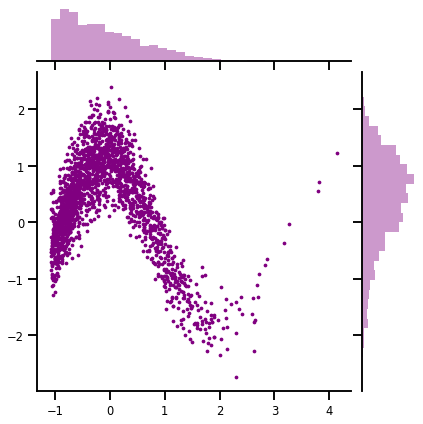

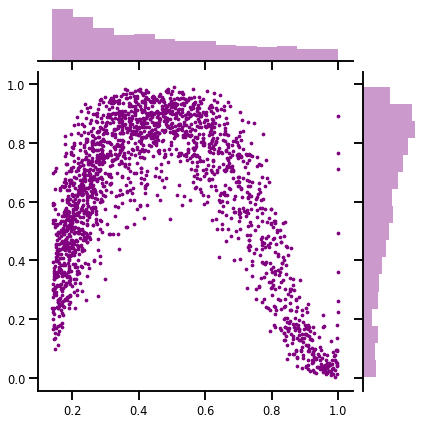

In [12]:
sns.jointplot(X_l2[:, 0], X_l2[:, 1], s=5, color='purple')
sns.jointplot(X_l1_approx[:, 0], X_l1_approx[:, 1], s=5, color='purple')

### Layer III - HouseHolder Transformation

#### Initialize Layer

In [13]:
from rbig_jax.transforms.parametric import HouseHolder

# layer parameters
n_reflections = 10

init_func = HouseHolder(n_reflections=n_reflections)


#### Initialize Parameters

In [14]:
# initialize the keys
rng, params_rng = jax.random.split(rng, 2)

# create layer
params, forward_f, inverse_f = init_func(rng=params_rng, n_features=n_features)

#### Forward/Inverse Transformation

In [15]:
%%time

# forward transformation
Z, log_abs_det = forward_f(params, X_l2)
X_l2_approx, log_abs_det = inverse_f(params, Z)

CPU times: user 157 ms, sys: 3.12 ms, total: 161 ms
Wall time: 157 ms


#### Demo Plot

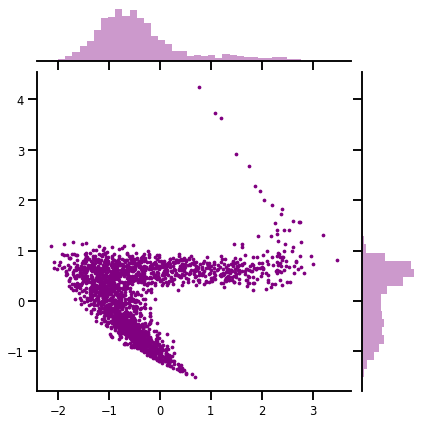

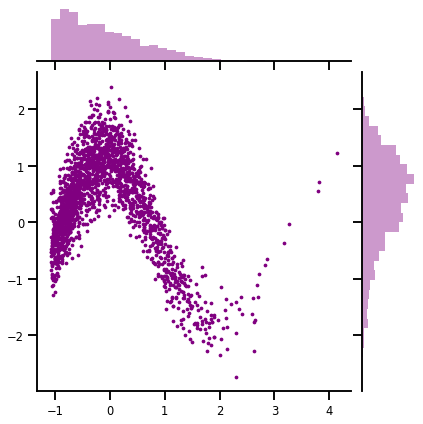

In [16]:
sns.jointplot(Z[:, 0], Z[:, 1], s=5, color='purple')
sns.jointplot(X_l2_approx[:, 0], X_l2_approx[:, 1], s=5, color='purple')

## Composing Transformations

So now we want to compose all of these transformations together:
* Mixture CDF
* Inverse Gauss CDF
* Orthogonal Rotation

In Gaussianization terms, we can think of this as as *block*. So we can stack these together to give us a final transformation.

In [17]:
# initialize list of bijectors
bijectors = []

# mixture gaussian cdf distribution, f:[-inf,inf] -> [0,1]
bijectors.append(
    MixtureGaussianCDF(n_components=n_components)
)
# Logit quantile function, f:[0,1] -> [-inf,inf]
bijectors.append(
    InverseGaussCDF()
)
# orthogonal rotation layer, f:[-inf,inf] -> [-inf,inf]
bijectors.append(
    HouseHolder(n_reflections=n_reflections)
)


### Initialize All Parameters

So we follow the same steps as above. 

* Initialize the parameters with the number of features and a random number generator
* Stack them all together.

In [18]:
# initialize params stores
all_params, forward_funs, inverse_funs = [], [], []

# create keys for all inits
rng, *layer_rngs = jax.random.split(KEY, num=len(bijectors) + 1)

# loop through bijectors
for i_rng, init_f in zip(layer_rngs, bijectors):
    
    param, forward_f, inverse_f = init_f(rng=i_rng, n_features=n_features)
    
    # store functions and parameters
    all_params.append(param)
    forward_funs.append(forward_f)
    inverse_funs.append(inverse_f)

### Forward Transformation

And now we can loop through all of the parameters and forward functions to gaussianize the data.

In [19]:
# init log det
logabsdet = np.zeros(X.shape[0])

inputs = X

# loop through functions
for forward_f, iparams in zip(forward_funs, all_params):
    
    # calculate log determinant jacobian, transformation
    inputs, ilogabsdet = forward_f(iparams, inputs)
    logabsdet += ilogabsdet

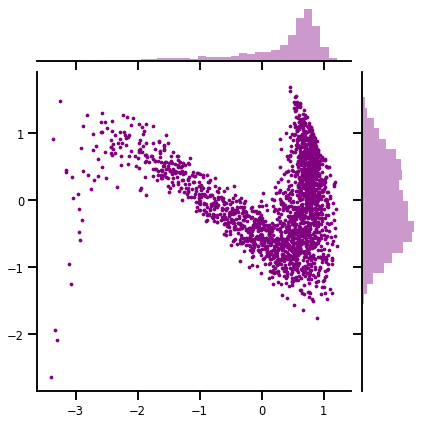

In [20]:
sns.jointplot(inputs[:, 0], inputs[:, 1], s=5, color='purple')

### Inverse Transformation

And to do the reverse, we do the same except in the inverse direction.

In [21]:
# init log det
logabsdet = np.zeros(X.shape[0])

X_approx = inputs

# loop through functions
for inverse_f, params in zip(inverse_funs[::-1], all_params[::-1]):
    
    # calculate log determin
    X_approx, ilogabsdet = inverse_f(params, X_approx)
    logabsdet += ilogabsdet

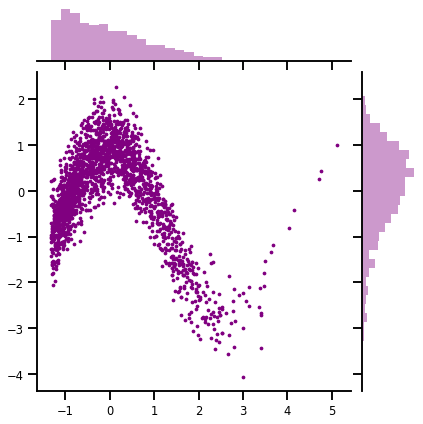

In [22]:
sns.jointplot(X_approx[:, 0], X_approx[:, 1], s=5, color='purple')

## More Layers

So now, we would want to add more layers! These are relatively simple transformations, so a single *block* will not result in Gaussianized data, even if we were to train for the best parameters.

We can always add more layers! Below we show an example of how to do so.

In [63]:
# from rbig_jax.transforms.logit import Logit
# from rbig_jax.transforms.parametric.svd import SVD

# model hyperparameters
n_components = 20
n_reflections = 2
n_features = data.shape[1]


n_layers = 4

bijectors = []

for _ in range(n_layers):
    # mixture gaussian cdf distribution, f:[-inf,inf] -> [0,1]
    bijectors.append(
        MixtureGaussianCDF(n_components=n_components)
    )
    # Logit quantile function, f:[0,1] -> [-inf,inf]
    bijectors.append(
        InverseGaussCDF()
    )
    # orthogonal rotation layer
    bijectors.append(
        HouseHolder(n_reflections=n_reflections)
    )
    



### Helper Function: Composite Transform

So we don't really want to have to go through all of the set up again, i.e. all of the params, functions, keys, etc. So we can use the `CompositeTransform` function within the library to handle that preamble for us.

In [64]:
from rbig_jax.transforms.base import CompositeTransform

# compose all transformations into a single chain
init_func = CompositeTransform(bijectors)

And below we see that it's the exact same code as the previous layers!

In [65]:
seed = 123
flow_rng = jax.random.PRNGKey(seed)

# create layer
params, forward_f, inverse_f = init_func(rng=flow_rng, n_features=n_features)

### Forward Transformation

So now the forward transformation is taken care of in a single function call.

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


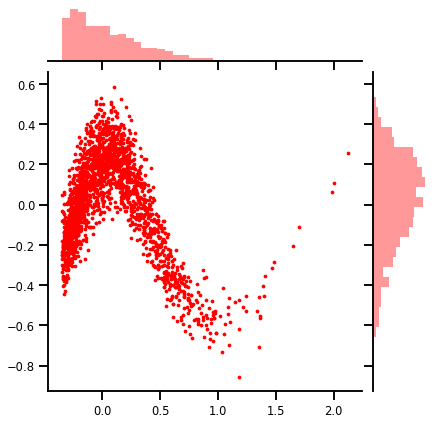

In [66]:
Z, _ = forward_f(params, X)

sns.jointplot(Z[:, 0], Z[:, 1], s=5, color='red')

### Inverse Transformation

As well as the inverse transformation

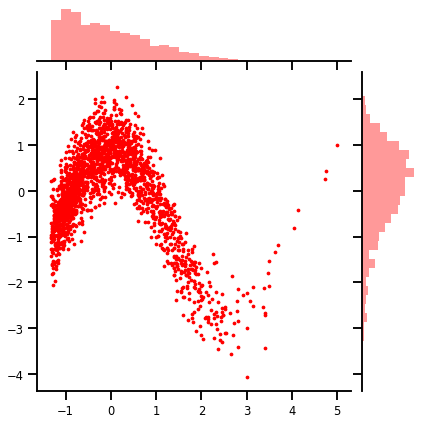

In [67]:
X_approx, _ = inverse_f(params, Z)

sns.jointplot(X_approx[:, 0], X_approx[:, 1], s=5, color='red')

## Training

None of these parameters are optimized. We need to find the best set of parameters so that the data in the latent domain is Gaussian.

### Loss Function

Because we have access to the log determinant Jacobian of our transformation, we can directly minimize the log determinant Jacobian. So let's minimize that. Because it's Gaussianization, we assume that the base distribution is a Gaussian.

In [68]:

# initialize base distribution
base_dist = jax.scipy.stats.norm

# create loss function
def nll_loss(params, inputs):
    # forward pass to the latent space
    outputs, logabsdet = forward_f(params, inputs)
    
    # log probability in the latent domain
    latent_log_prob = base_dist.logpdf(outputs).sum(axis=1)
    
    # log probability of the data
    log_prob = latent_log_prob + logabsdet
    
    # negative log likelihood
    nll = - log_prob.mean()
    
    return nll

In [69]:
nll_loss(params, X)

DeviceArray(4.468125, dtype=float32)

### Optimizer

We will use the standard Adam optimizer with a learning rate of `0.01`. It's a reasonable first guess. This data isn't very complex, so this should do fine. We will also train in batches of `128` to ease the optimization procedure.

In [70]:
from jax.experimental import optimizers

lr = 1e-4
epochs = 1_000
batch_size = 128


opt_init, opt_update, get_params = optimizers.adam(step_size=lr)
opt_state = opt_init(params)

### Grad Step

So this is preamble for almost all of the code in JAX.

In [71]:
def step(i, opt_state, inputs):
    # get the parameters from the state
    params = get_params(opt_state)
    # calculate the loss AND the gradients
    loss, gradients = jax.value_and_grad(nll_loss)(params, inputs)
    
    # return loss AND new opt_state
    return loss, opt_update(i, gradients, opt_state)

# TO MAKE IT FAST
train_op = jax.jit(step)

### Training Loop


We're going to generate a bit more data so that we can really learn this distribution.


In [72]:
n_samples = 5_000
n_features = 2
data = get_classic(n_samples)

In [73]:
import itertools
from jax import device_put
import tqdm
from jax import random


# initialize parameters
key = random.PRNGKey(123)
itercount = itertools.count()
permute_rng, rng = random.split(key)

train_data = np.array(data, dtype=jnp.float32)

losses = list()

pbar = tqdm.trange(epochs)


with pbar:
    for i in pbar:

        # batch processing
        permute_rng, rng = random.split(rng)

        # randomly shuffle the data
        train_data = random.permutation(permute_rng, train_data)

        # Train
        avg_loss = []

        for batch_index in range(0, n_samples, batch_size):
            # compute loss
            loss, opt_state = train_op(
                next(itercount), 
                opt_state,
                train_data[batch_index:batch_index+batch_size],
            )
            
            
            # append batch
            avg_loss.append(float(loss))
        # average loss
        batch_loss = np.mean(np.stack(avg_loss))

        # Log losses
        losses.append(batch_loss)
        pbar.set_postfix({"loss": f"{batch_loss:.4f}"})

100%|██████████| 1000/1000 [02:31<00:00,  6.62it/s, loss=1.4683]


If you were watching the loop, you'll notice that it was quite slow in the beginning but then it go faster towards the end. This is due to the `JIT` compilation step. So it compiles the function down to XLA code on the first run. Then every subsequent run will be faster. This is very similar to Julia and what makes Julia so fast.

### Losses

It was apparent from the training loop that the negative log-likelihood loss was going down. But we can also plot the losses because we have been tracking them.

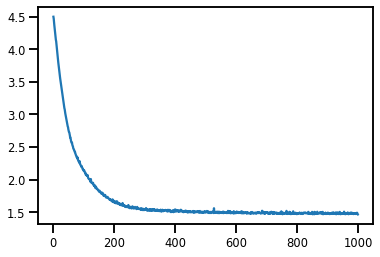

In [74]:
plt.plot(losses)

### Final Parameters

We also need to extract the final trained parameters from the `opt_state`. 

In [75]:
final_params = get_params(opt_state)

### Forward Transformation

And we can use these final params and propagate them through the forward function to the latent domain.

In [76]:
# forward transformation
Z, logabsdet = forward_f(final_params, train_data)

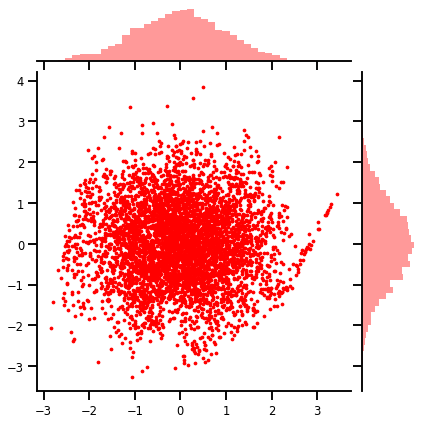

In [77]:
sns.jointplot(Z[:, 0], Z[:, 1], s=5, color='red')

## Application I - Generating Samples

So now that we have learned an invertible transformation, we can generate samples that should be close to original data domain. 

In [78]:
# generate samples in the latent domain
n_gen_samples = 2_000

key = jax.random.PRNGKey(42)
Z_samples = jax.random.normal(key, shape=(n_gen_samples, n_features))

# inverse transformation
X_samples, _ = inverse_f(final_params, Z_samples)

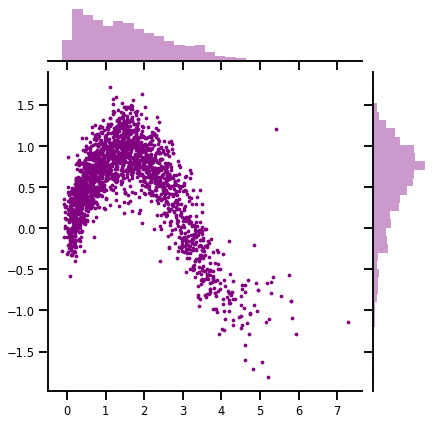

In [79]:
sns.jointplot(X_samples[:, 0], X_samples[:, 1], s=5, color='purple')

## Application II - Density Estimation

In [80]:
from rbig_jax.data import generate_2d_grid

In [81]:
n_grid = 1_000
buffer = 0.1
xyinput = generate_2d_grid(train_data, n_grid=n_grid, buffer=buffer)

In [82]:
%%time

# forward transformation
Z, logabsdet = forward_f(final_params, xyinput)

CPU times: user 33.6 s, sys: 12.8 s, total: 46.4 s
Wall time: 6.66 s


In [83]:
# log probability
latent_prob = jax.scipy.stats.norm.logpdf(Z).sum(axis=1)

# change of variables
log_prob = latent_prob + logabsdet

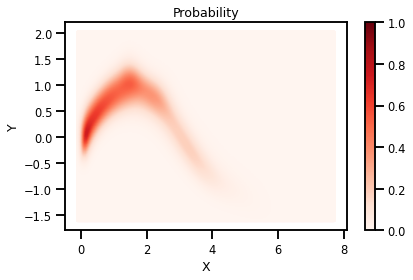

In [84]:
cmap = "Reds"
probs = np.exp(log_prob)
# probs = np.clip(probs, 0.0, 1.0)
title = "Probability"

fig, ax = plt.subplots()
h = ax.scatter(xyinput[:, 0], xyinput[:, 1], s=1, c=probs,  cmap=cmap, vmin=0.0, vmax=1.0)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()
plt.show()

### Demo of Transform between Layers

In [45]:
# # initialize figure
# fig, ax = plt.subplots()
# camera = Camera(fig)

# outputs = data
# # ax.scatter(outputs[:, 0], outputs[:, 1], s=1, color="Red")
# # ax.set_xlim([outputs[:,0].min()-.1, outputs[:,0].max()+.1])
# # ax.set_ylim([outputs[:,1].min()-.1, outputs[:,1].max()+.1])
# # ax.text(0.4, 1.05, f"Layer: {0}", transform=ax.transAxes, fontsize=20)
# # camera.snap()


# for ilayer, itransform in enumerate(gf_model.bijections._transforms):
#     outputs = itransform.transform(outputs)    
    
#     if (ilayer + 1) % 3 == 0:
#         # make predictions
#         ax.scatter(outputs[:, 0], outputs[:, 1], s=1, color="Red")
#         ax.set_xlim([outputs[:,0].min()-.1, outputs[:,0].max()+.1])
#         ax.set_ylim([outputs[:,1].min()-.1, outputs[:,1].max()+.1])
#         ax.text(0.4, 1.05, f"Layer: {int((ilayer+1)/3)}", transform=ax.transAxes, fontsize=20)
#         camera.snap()

# animation = camera.animate(1_500)
# # HTML(animation.to_html5_video())
# animation.save('./layers.gif')